In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.ticker as ticker
from category_encoders import TargetEncoder

## Funções a serem usadas:
Abaixo estão algumas funções que foram criadas durante o processo de criação do notebook, visando eliminar a repetição de código.

In [531]:
# Cria um histograma e um boxplot para uma coluna a ser especificada
def plot_histogram_boxplot(data, column):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))  # Cria uma figura com 1 linha e 2 colunas de subplots

    # Histograma
    sns.histplot(data[column], bins=50, kde=True, ax=ax[0])  # Atribui o primeiro gráfico ao primeiro subplot
    ax[0].set_title(f'Distribuição de {column}')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Frequência')

    if column == 'preco':
        ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    # Boxplot
    sns.boxplot(x=data[column], ax=ax[1])  # Atribui o segundo gráfico ao segundo subplot
    ax[1].set_title(f'Boxplot de {column}')

    if column == 'preco':
        ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    plt.show()

In [532]:
# Cria um countplot para ver a distribuição de determinadas categorias em uma coluna
def plot_top_categories(data, column, n=15):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=data, order=data[column].value_counts().iloc[:n].index)
    plt.title(f'{column.capitalize()} Mais Comuns')
    plt.xlabel('Contagem')
    plt.ylabel(column.capitalize())
    plt.show()

In [533]:
# Busca filtrar com base no estado e em outros fatores, calculando a mediana para responder as perguntas de negócio
def best_state_for_price(df, condition, min_car_count, price_column):
    # Aplicar a condição de filtro
    filtered_df = df[condition]

    # Contagem de carros por estado
    state_counts = filtered_df.groupby('estado_vendedor').size()

    # Filtrar estados que têm mais do que o mínimo especificado de carros
    filtered_states = state_counts[state_counts > min_car_count].index

    # Aplicar filtro de estados
    filtered_df = filtered_df[filtered_df['estado_vendedor'].isin(filtered_states)]

    # Calcular a mediana do preço para cada estado
    state_prices = filtered_df.groupby('estado_vendedor')[price_column].median().sort_values(ascending=True)

    # Encontrar o estado com a menor mediana de preço
    best_state = state_prices.idxmin()

    return best_state, state_prices


In [534]:
def preprocess_data(df, cat_cols, bin_cols, num_cols, target=None, drop_cols=None, te=None):
    # Tratando valores nulos
    df['veiculo_único_dono'].fillna('Não é único dono', inplace=True)
    df['revisoes_concessionaria'].fillna('Revisões não feitas pela concessionária', inplace=True)
    df['ipva_pago'].fillna('IPVA não pago', inplace=True)
    df['veiculo_licenciado'].fillna('Não licenciado', inplace=True)
    df['garantia_de_fábrica'].fillna('Sem garantia de fábrica', inplace=True)
    df['revisoes_dentro_agenda'].fillna('Revisões não feitas pela agenda do carro', inplace=True)

    # Codificando as colunas binárias em 0 e 1
    le = LabelEncoder()
    for col in bin_cols:
        df[col] = le.fit_transform(df[col])

    # Codificando as colunas categóricas usando TargetEncoder
    if te is None and target is not None:
        te = TargetEncoder(cols=cat_cols)
        te.fit(df[cat_cols], df[target])
    if te is not None:
        df[cat_cols] = te.transform(df[cat_cols])

    # Descartando colunas que não serão utilizadas
    if drop_cols:
        df.drop(drop_cols, axis=1, inplace=True)

    # Dividindo os dados em features e target, se disponível
    if target:
        X = df.drop(target, axis=1)
        y = df[target]
        return X, y, te
    else:
        return df, te


Aqui estamos importando os dados disponibilizados em 2 dataframes diferentes, um para testes e outro para treinamento.

In [535]:
cars_train = 'https://raw.githubusercontent.com/eduardosalvarenga/dados/main/cars_train.csv'
cars_test = 'https://raw.githubusercontent.com/eduardosalvarenga/dados/main/cars_test.csv'

# Carrega os datasets com o encoding 'UTF-16 LE' e o uso de tab de separator
train_data = pd.read_csv(cars_train, encoding='UTF-16 LE', sep='\t')
test_data = pd.read_csv(cars_test, encoding='UTF-16 LE', sep='\t')

# Mostra as primeiras colunas do conjunto de treino
train_data.head()

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,...,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
0,300716223898539419613863097469899222392,8.00,NISSAN,KICKS,1.6 16V FLEXSTART SL 4P XTRONIC,2017,2017.00,67772.00,CVT,4,...,False,NaN,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,NaN,NaN,74732.59
1,279639842134129588306469566150288644214,8.00,JEEP,COMPASS,2.0 16V FLEX LIMITED AUTOMÁTICO,2017,2017.00,62979.00,Automática,4,...,False,Aceita troca,NaN,NaN,IPVA pago,NaN,NaN,NaN,NaN,81965.33
2,56414460810621048900295678236538171981,16.00,KIA,SORENTO,2.4 16V GASOLINA EX 7L AWD AUTOMÁTICO,2018,2019.00,44070.00,Automática,4,...,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162824.81
3,56862509826849933428086372390159405545,14.00,VOLKSWAGEN,AMAROK,2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIES...,2013,2015.00,85357.00,Automática,4,...,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,123681.36
4,338980975753200343894519909855598027197,8.00,SSANGYONG,KORANDO,2.0 GLS 4X4 16V TURBO DIESEL 4P AUTOMÁTICO,2013,2015.00,71491.00,Automática,4,...,False,NaN,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN,82419.76


## Análises Estatísticas e Explorátoria dos Dados

**1) Para dados numéricos**
*   Criado Histograma e Boxplot para ver a distribuição dos dados
*   Criado um heatmap para ver a correlação das variáveis numéricas

**2) Para dados categóricos**
*   Criado countplots para ver a contagem de determinadas categorias em algumas colunas.






Começamos verificando os tipos de dados disponíveis em cada coluna.<br />
Logo de cara percebemos que a coluna `veiculo_alienado` possui todos os campos como nulo.<br />
Passamos a pensar também o que significa algumas colunas como `revisoes_concessionaria` possuir grandes quantidades de valores nulos

In [536]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       29584 non-null  object 
 1   num_fotos                29407 non-null  float64
 2   marca                    29584 non-null  object 
 3   modelo                   29584 non-null  object 
 4   versao                   29584 non-null  object 
 5   ano_de_fabricacao        29584 non-null  int64  
 6   ano_modelo               29584 non-null  float64
 7   hodometro                29584 non-null  float64
 8   cambio                   29584 non-null  object 
 9   num_portas               29584 non-null  int64  
 10  tipo                     29584 non-null  object 
 11  blindado                 29584 non-null  object 
 12  cor                      29584 non-null  object 
 13  tipo_vendedor            29584 non-null  object 
 14  cidade_vendedor       

In [537]:
train_data.drop('veiculo_alienado', axis=1, inplace=True)
test_data.drop('veiculo_alienado', axis=1, inplace=True)

Para melhor sabermos sobre os dados nulos, foi optado por buscar a quantidade de valores únicos em cada coluna. <br />
A coluna `revisoes_concessionaria` que havíamos destacado antes possui 1 valor, o que, junto de uma lida sobre cada coluna, que foi fornecido, nos faz assumir que quando a resposta é negativa no caso "Não houve revisão", o valor vem como Nulo.

Analisamos também a frequência relativa de cada valor único em cada coluna que possuí entre 1 e 10 valores.

In [538]:
unique_counts = train_data.nunique()
columns_with_nulls = train_data.isnull().sum()

# Criar um DataFrame com as informações
data = {
    'Valores Únicos': unique_counts,
    'Valores Nulos': columns_with_nulls
}
df = pd.DataFrame(data)

# Exibir o DataFrame
df

,Valores Únicos,Valores Nulos
id,29584,0
num_fotos,14,177
marca,40,0
modelo,457,0
versao,1916,0
ano_de_fabricacao,35,0
ano_modelo,17,0
hodometro,26004,0
cambio,7,0
num_portas,3,0


In [539]:
# Selecionar colunas com mais de 1 e menos de 10 valores únicos
columns_to_check = train_data.columns[(train_data.nunique() > 1) & (train_data.nunique() < 10)]

# Criar um novo DataFrame para armazenar as informações das frequências relativas
value_counts_df = pd.DataFrame(index=columns_to_check, columns=["Valor Único", "Frequência Relativa"])

# Calcular a frequência relativa de cada valor único nas colunas selecionadas
for column in columns_to_check:
    # Calcular a frequência relativa
    value_counts = train_data[column].value_counts(normalize=True)
    # Adicionar as informações ao DataFrame
    value_counts_df.loc[column, "Valor Único"] = value_counts.index.tolist()
    value_counts_df.loc[column, "Frequência Relativa"] = value_counts.values.tolist()

# Exibir o novo DataFrame com as frequências relativas
value_counts_df

,Valor Único,Frequência Relativa
cambio,"[Automática, Manual, CVT, Automatizada, Automa...","[0.7620673336938886, 0.16863845321795565, 0.06..."
num_portas,"[4, 2, 3]","[0.9700175770686857, 0.029340183883180097, 0.0..."
tipo,"[Sedã, Hatchback, Picape, Utilitário esportivo...","[0.5553339643050298, 0.16644131963223363, 0.16..."
blindado,"[N, S]","[0.9916170903190914, 0.0083829096809086]"
cor,"[Branco, Preto, Prata, Cinza, Dourado, Verde, ...","[0.708119253650622, 0.17766360194699837, 0.058..."
tipo_vendedor,"[PF, PJ]","[0.6059356408869659, 0.39406435911303406]"
anunciante,"[Pessoa Física, Loja, Concessionária, Acessóri...","[0.6084031909140075, 0.3339305029745809, 0.057..."
entrega_delivery,"[False, True]","[0.79776230394808, 0.20223769605191996]"
troca,"[False, True]","[0.8289277988101676, 0.17107220118983235]"


In [540]:
# Lista de colunas com dados nulos
cols_with_nulls = ['num_fotos', 'dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda']

# Para cada coluna, imprima os valores únicos
for col in cols_with_nulls:
    print(f"Valores únicos para {col}: {train_data[col].unique()}")

Valores únicos para num_fotos: [ 8. 16. 14. 13. 15. 20. 11.  9. 18. 17. 12. nan 19. 21. 10.]
Valores únicos para dono_aceita_troca: [nan 'Aceita troca']
Valores únicos para veiculo_único_dono: [nan 'Único dono']
Valores únicos para revisoes_concessionaria: ['Todas as revisões feitas pela concessionária' nan]
Valores únicos para ipva_pago: ['IPVA pago' nan]
Valores únicos para veiculo_licenciado: ['Licenciado' nan]
Valores únicos para garantia_de_fábrica: [nan 'Garantia de fábrica']
Valores únicos para revisoes_dentro_agenda: [nan 'Todas as revisões feitas pela agenda do carro']


Tendo esta ideia inicial, passamos a observar as variáveis numéricas e alguns de seus dados estatísticos como valor mínimo, máximo, sua média, etc.

Aqui conseguimos notar que o dataset é atualizado até o ano atual pois o valor máximo do ano_modelo é 2023. Notamos também que o desvio padrão tanto do hodometro quanto do preço é alto.

In [541]:
# Configurar a opção de exibição para formato decimal completo
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
train_data.describe()

,num_fotos,ano_de_fabricacao,ano_modelo,hodometro,num_portas,preco
count,29407.00,29584.00,29584.00,29584.00,29584.00,29584.00
mean,10.32,2016.76,2017.81,58430.59,3.94,133023.88
std,3.49,4.06,2.67,32561.77,0.34,81662.87
min,8.00,1985.00,1997.00,100.00,2.00,9869.95
25%,8.00,2015.00,2016.00,31214.00,4.00,76571.77
50%,8.00,2018.00,2018.00,57434.00,4.00,114355.80
75%,14.00,2019.00,2020.00,81953.50,4.00,163679.62
max,21.00,2022.00,2023.00,390065.00,4.00,1359812.89


Abaixo começamos a analisar melhor as variáveis numéricas, buscando através de um histograma encontrar relações de correlação entre as variáveis, principalmente com a variável preço.

Notamos que por mais que aja algumas correlações de nível mediano (com o preço), elas não parecem ser muito grandes. Conseguimos notar porém uma correlação forte entre as duas colunas de ano, assim como uma correlação negativa forte entre o a coluna de hodometro e as colunas de ano.

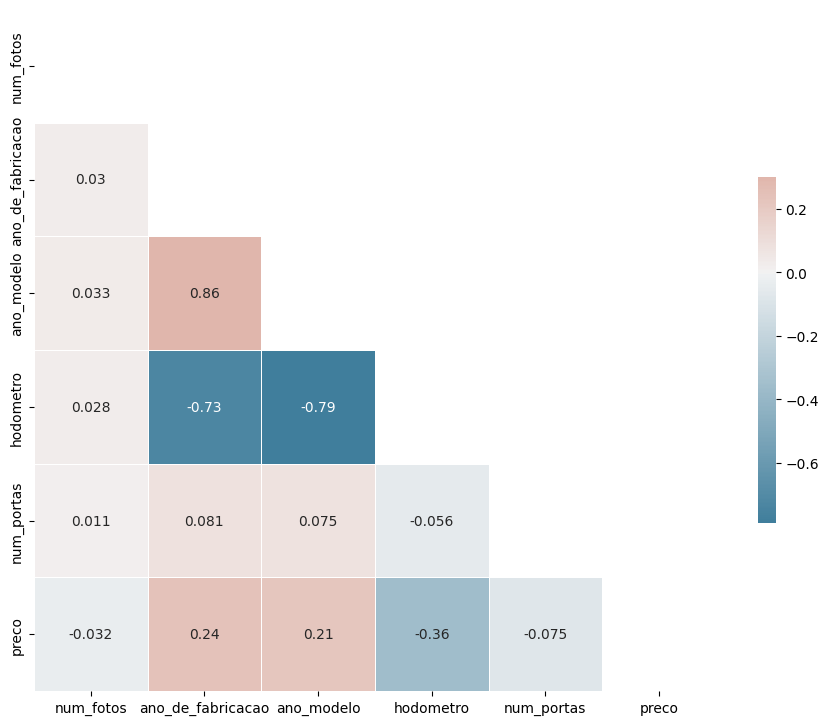

In [542]:
# Selecionar colunas numéricas
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Calcular a correlação
corr = train_data[num_cols].corr()

# Aprimoramente do plot
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Para as variáveis numéricas com certa correlação com o *target* preço, plotamos um histograma e um boxplot para melhor vermos a distribuição.

Quanto aos anos conseguimos notar que os dados que possuímos possuem maior concentração entre os anos 2015-2020, com poucos *outliers* no Ano do Modelo e alguns no ano de fabricação. Isto nos mostra que carros com menos de 10 anos (ou seja, mais novos) costumam ser os mais vendidos.

Quanto ao hodometro, notamos uma maior frequência entre 25.000-75.000, este possuindo um maior número de *outliers*, podendo ser algo que representa que carros seminovos atraem mais clientes.

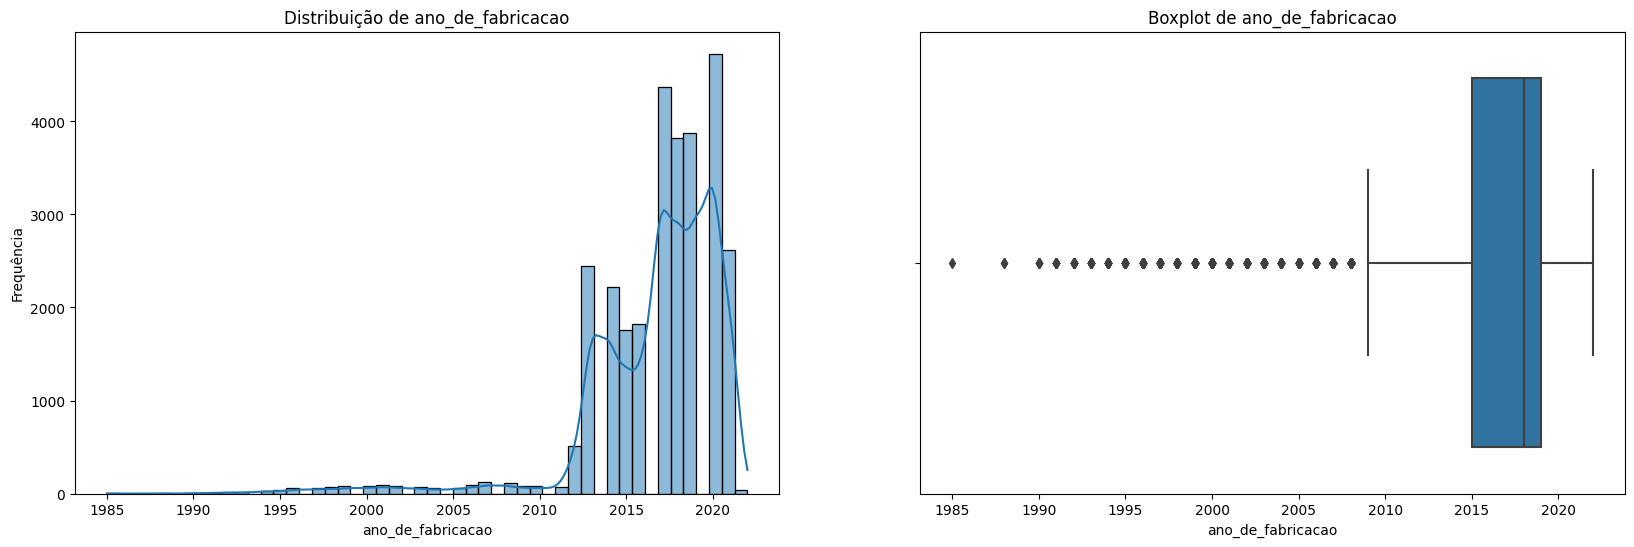

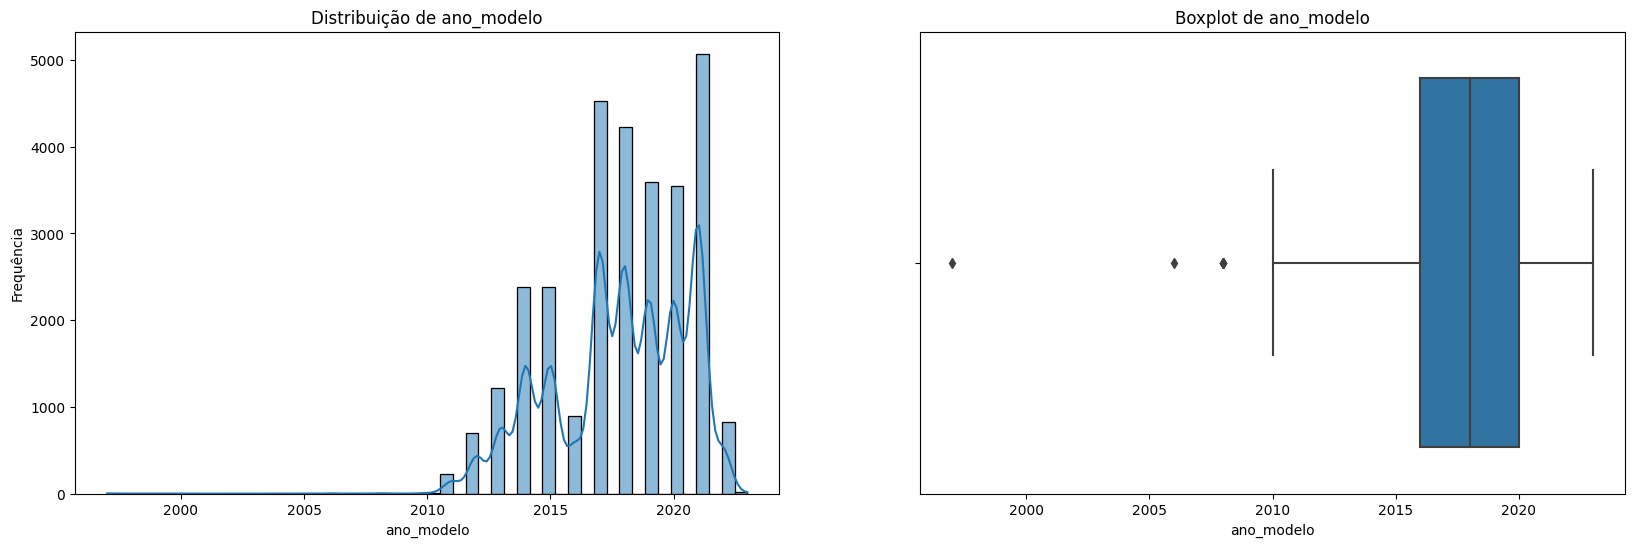

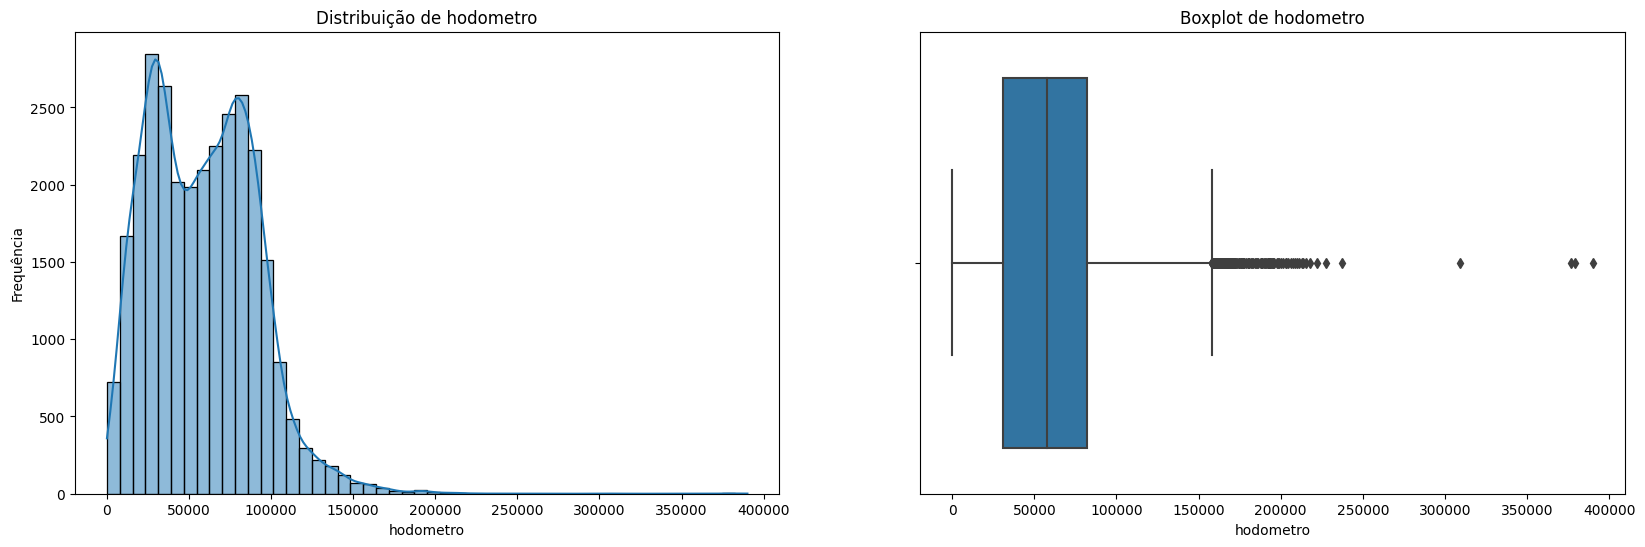

In [543]:
# Para as variáveis numéricas
num_cols = ['ano_de_fabricacao', 'ano_modelo', 'hodometro']
for col in num_cols:
    plot_histogram_boxplot(train_data, col)

## Perguntas de Negócio

Abaixo começaremos analisar e responder algumas perguntas e hipóteses sobre os dados. Antes de começarmos a responder elas, optamos por definir as seguintes características:

**Melhor Estado:** foi definido como o estado com a maior mediana de preço de venda dos carros. Devido a grande diferença de informações disponíveis (O estado de São Paulo possuí uma contagem muito acima de qualquer outro estado) buscou-se responder as perguntas de duas formas: considerando estados que possuem uma certa amostragem dos dados e considerando todos os estados menos o de SP. Isto foi feito para tentar considerar possíveis distorções nos dados devido a vasta quantidade de informação do Estado de São Paulo.


**Carros de marcas populares:** foi definido como os carros pertencentes as 5 marcas mais identificadas no conjunto.

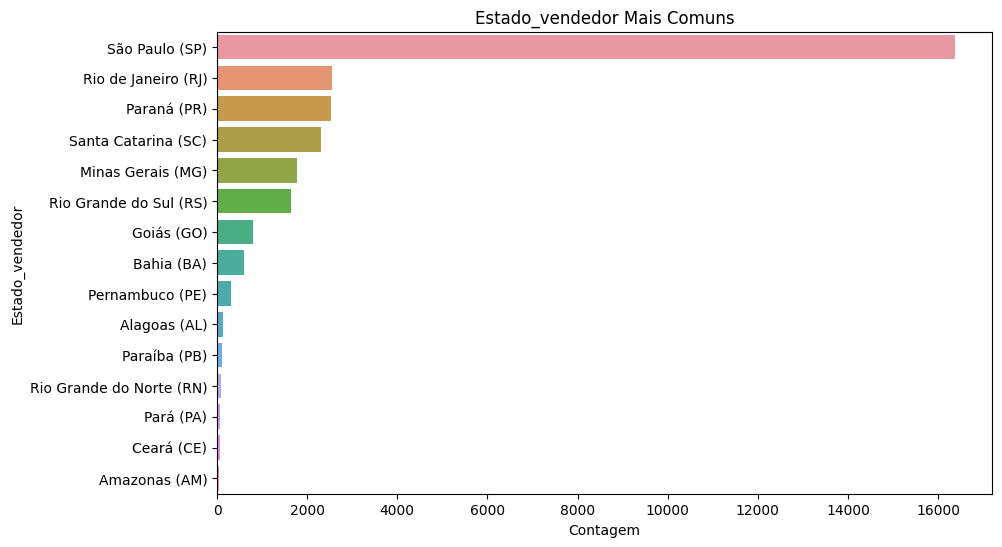

In [544]:
plot_top_categories(train_data, 'estado_vendedor')

### 1. Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?

Aqui além das determinações explicadas acima, também buscou-se considerar carros com o ano de fabricação em sua mediana assim como carros com odômetros ao redor de seu primeiro e terceiro quartil, visando eliminar os outliers que encontramos anteriormente.

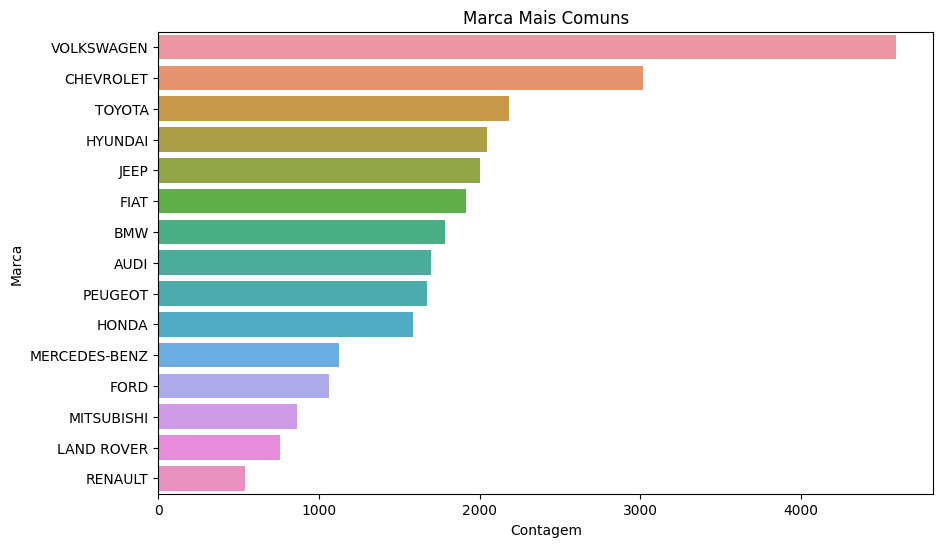

In [545]:
plot_top_categories(train_data, 'marca')

In [546]:
popular_brands = ['VOLKSWAGEN', 'CHEVROLET', 'TOYOTA', 'HYUNDAI', 'JEEP']
popular_cars = train_data[train_data['marca'].isin(popular_brands)]

condition1 = popular_cars['ano_modelo'].isin([2015, 2016, 2017, 2018, 2019, 2020])
best_state1, state_prices1 = best_state_for_price(popular_cars, condition1, 200, 'preco')
print("Melhor estado para venda de carros populares de modelos recentes:", best_state1)

best_state1_exclude_sp, state_prices1_exclude_sp = best_state_for_price(popular_cars[popular_cars['estado_vendedor'] != 'São Paulo (SP)'], condition1, 200, 'preco')
print("Melhor estado para venda de carros populares de modelos recentes (Excluindo São Paulo):", best_state1_exclude_sp)


Melhor estado para venda de carros populares de modelos recentes: São Paulo (SP)
Melhor estado para venda de carros populares de modelos recentes (Excluindo São Paulo): Bahia (BA)


<ipython-input-533-a97b2c4cceb4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[condition]


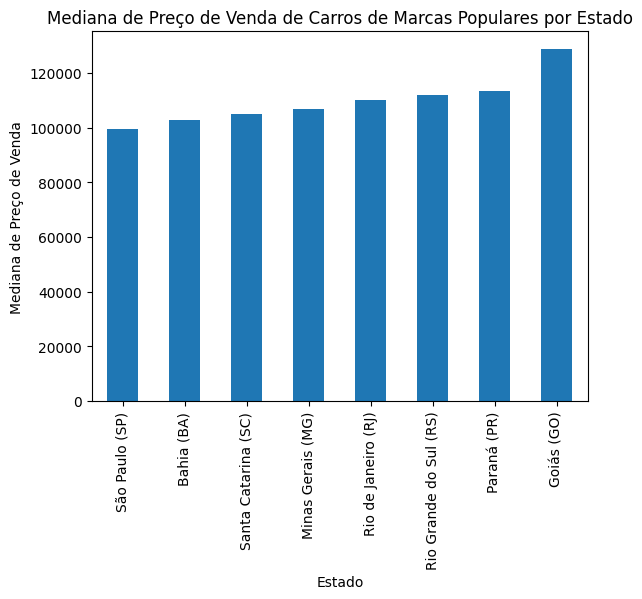

In [547]:
state_prices1.plot(kind='bar')
plt.xlabel('Estado')
plt.ylabel('Mediana de Preço de Venda')
plt.title('Mediana de Preço de Venda de Carros de Marcas Populares por Estado')
plt.show()

Com o resultado acima o que notamos é que o estado de São Paulo é o melhor para se vender carros de marcas populares. Se o desconsiderarmos devido a sua diferença de dados, o estado da Bahia é o mais propício quando consideramos ano e preço.

In [548]:
popular_cars = train_data[train_data['marca'].isin(popular_brands)]

# Categorize mileage
mileage_bins = popular_cars['hodometro'].quantile([0.25, 0.75])

# Create a new condition that selects only cars with mileage between the first and third quartile
condition2 = (popular_cars['hodometro'] > mileage_bins[0.25]) & (popular_cars['hodometro'] < mileage_bins[0.75])

# Now you can use this condition along with condition1 to filter the cars
filtered_cars = popular_cars[condition1 & condition2]

best_state1, state_prices1 = best_state_for_price(filtered_cars, condition1, 200, 'preco')
print("Melhor estado para venda de carros populares de modelos recentes:", best_state1)

best_state1_exclude_sp, state_prices1_exclude_sp = best_state_for_price(filtered_cars[filtered_cars['estado_vendedor'] != 'São Paulo (SP)'], condition1, 200, 'preco')
print("Melhor estado para venda de carros populares de modelos recentes (Excluindo São Paulo):", best_state1_exclude_sp)


Melhor estado para venda de carros populares de modelos recentes: São Paulo (SP)
Melhor estado para venda de carros populares de modelos recentes (Excluindo São Paulo): Santa Catarina (SC)


<ipython-input-533-a97b2c4cceb4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[condition]
<ipython-input-533-a97b2c4cceb4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[condition]


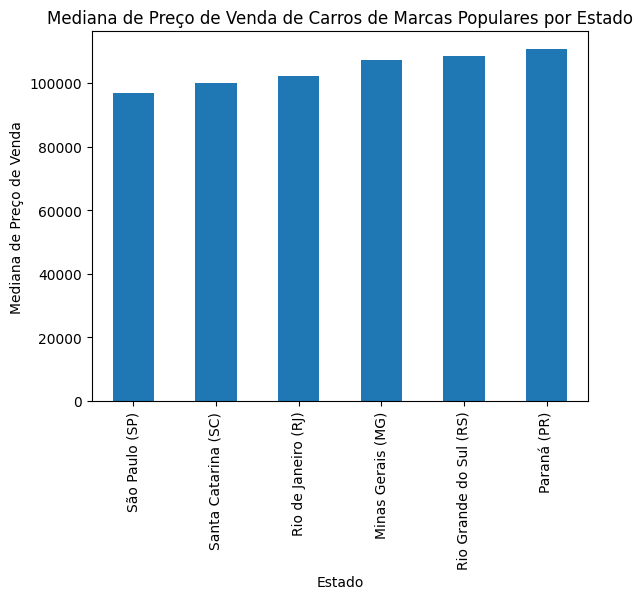

In [549]:
state_prices1.plot(kind='bar')
plt.xlabel('Estado')
plt.ylabel('Mediana de Preço de Venda')
plt.title('Mediana de Preço de Venda de Carros de Marcas Populares por Estado')
plt.show()

Quando passamos a considerar apenas carros que possuem uma quilometragem entre o primeiro e o terceiro quartil, o segundo estado mais propício passa a ser Santa Catarina.

Isso nos indica que o estado da Bahia pode ser mais ideal para a venda de carros com uma quilometragem mais perto da máxima e mínima do conjunto de dados.

### 2. Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?


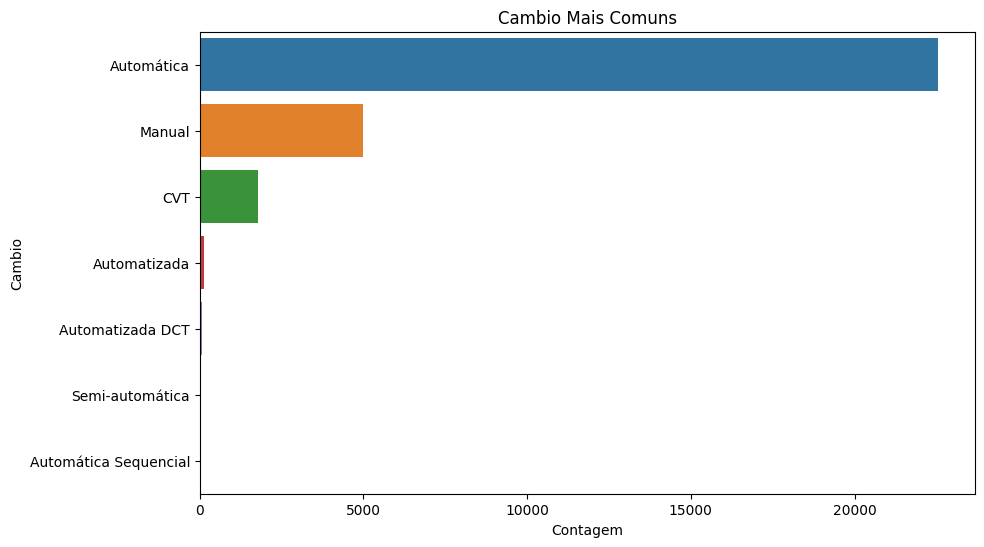

In [550]:
plot_top_categories(train_data, 'cambio')

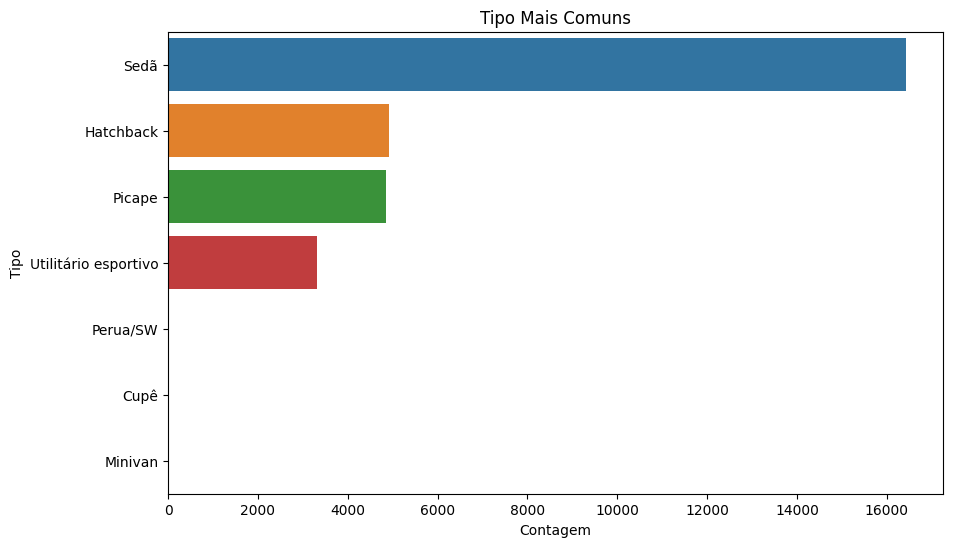

In [551]:
plot_top_categories(train_data, 'tipo')

In [552]:
automatic_transmissions = ['Automática', 'Automatizada', 'Automatizada DCT', 'Automática Sequencial']

condition2 = (train_data['tipo'] == 'Picape') & (train_data['cambio'].isin(automatic_transmissions))
best_state2, state_prices2 = best_state_for_price(train_data, condition2, 300, 'preco')
print("Melhor estado para comprar picapes com transmissão automática:", best_state2)

Melhor estado para comprar picapes com transmissão automática: Rio de Janeiro (RJ)


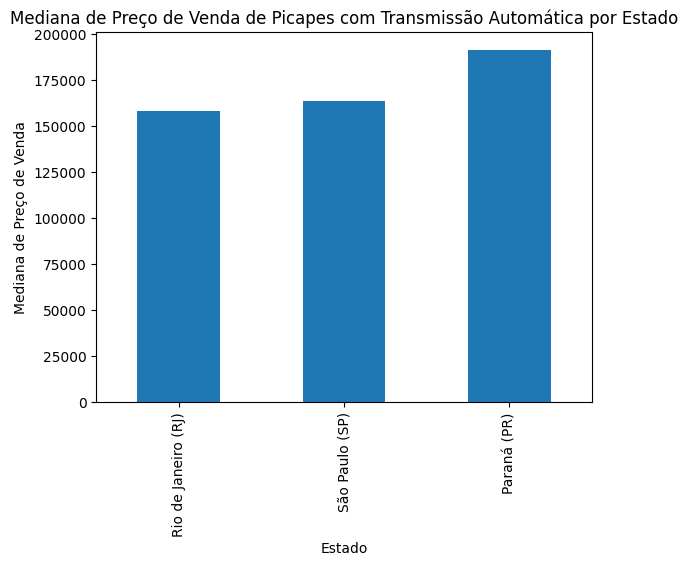

In [553]:
state_prices2.plot(kind='bar')
plt.xlabel('Estado')
plt.ylabel('Mediana de Preço de Venda')
plt.title('Mediana de Preço de Venda de Picapes com Transmissão Automática por Estado')
plt.show()

Aqui conseguimos ver que o estado do Rio de Janeiro possui uma melhor mediana de preço de venda para Picapes de Transmissão Automática.

### 3. Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

In [554]:
condition3 = train_data['garantia_de_fábrica'] == 'Garantia de fábrica'
best_state3, state_prices3 = best_state_for_price(train_data, condition3, 300, 'preco')
print("Melhor estado para comprar carros com garantia de fábrica:", best_state3)

best_state3_exclude_sp, state_prices3_exclude_sp = best_state_for_price(train_data[train_data['estado_vendedor'] != 'São Paulo (SP)'], condition3, 300, 'preco')
print("Melhor estado para comprar carros com garantia de fábrica (Excluindo São Paulo):", best_state3_exclude_sp)


Melhor estado para comprar carros com garantia de fábrica: São Paulo (SP)
Melhor estado para comprar carros com garantia de fábrica (Excluindo São Paulo): Santa Catarina (SC)


<ipython-input-533-a97b2c4cceb4>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[condition]


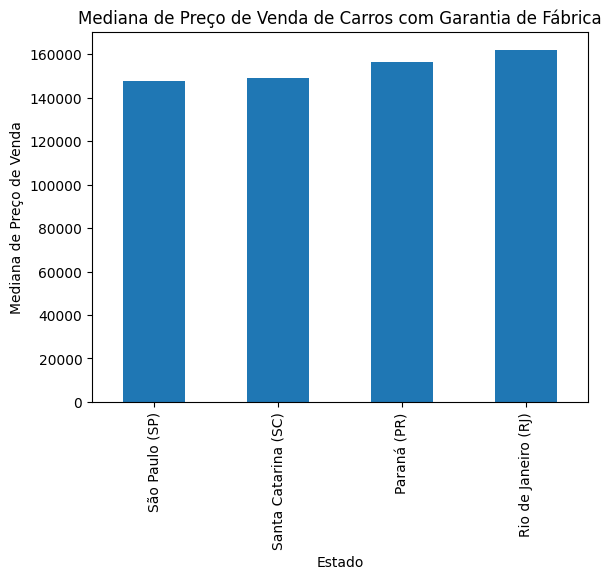

In [555]:
state_prices3.plot(kind='bar')
plt.xlabel('Estado')
plt.ylabel('Mediana de Preço de Venda')
plt.title('Mediana de Preço de Venda de Carros com Garantia de Fábrica')
plt.show()

O melhor estado para a venda de carros que ainda possuem garantia de fábrica é o estado de São Paulo, seguido pelo estado de Santa Catarina.

### Hipótese 1: Carros com uma transmissão automática são mais caros do que carros com uma transmissão manual

In [556]:
automatic_cars = train_data[train_data['cambio'].isin(automatic_transmissions)]['preco'].median()
manual_cars = train_data[train_data['cambio'] == 'Manual']['preco'].median()

print(f'Mediana de preço de carros automáticos: {automatic_cars}')
print(f'Mediana de preço de carros manuais: {manual_cars}')

Mediana de preço de carros automáticos: 126358.86073658477
Mediana de preço de carros manuais: 66962.03672233543


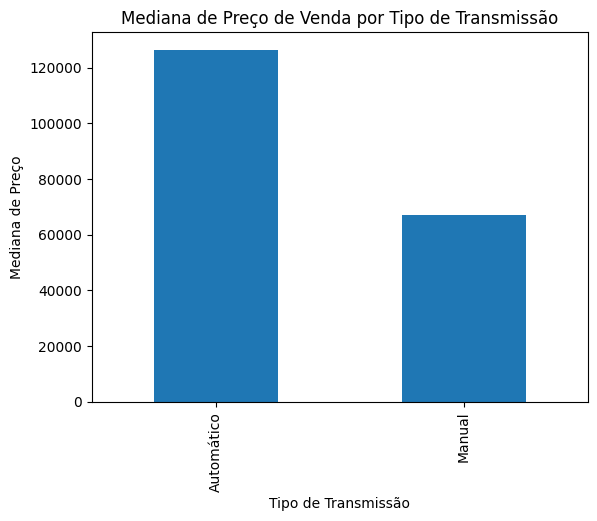

In [557]:
automatic_manual_prices = pd.Series([automatic_cars, manual_cars],
                                    index=['Automático', 'Manual'])
automatic_manual_prices.plot(kind='bar')
plt.xlabel('Tipo de Transmissão')
plt.ylabel('Mediana de Preço')
plt.title('Mediana de Preço de Venda por Tipo de Transmissão')
plt.show()

Com base nos dados analisados, a mediana do preço dos carros com transmissão automática é significativamente maior do que a dos carros com transmissão manual. Portanto, a hipótese que formulamos de que "Carros com uma transmissão automática são mais caros do que carros com uma transmissão manual" é apoiada pelos dados.

### Hipótese 2: Carros de único dono são mais caros do que carros que tiveram mais de um dono


In [558]:
single_owner_cars = train_data[train_data['veiculo_único_dono'] == 'Único dono']['preco'].median()
multiple_owner_cars = train_data[train_data['veiculo_único_dono'].isnull()]['preco'].median()

print(f'Mediana de preço de carros de único dono: {single_owner_cars}')
print(f'Mediana de preço de carros de múltiplos donos: {multiple_owner_cars}')

Mediana de preço de carros de único dono: 125767.85901593976
Mediana de preço de carros de múltiplos donos: 106966.35542439396


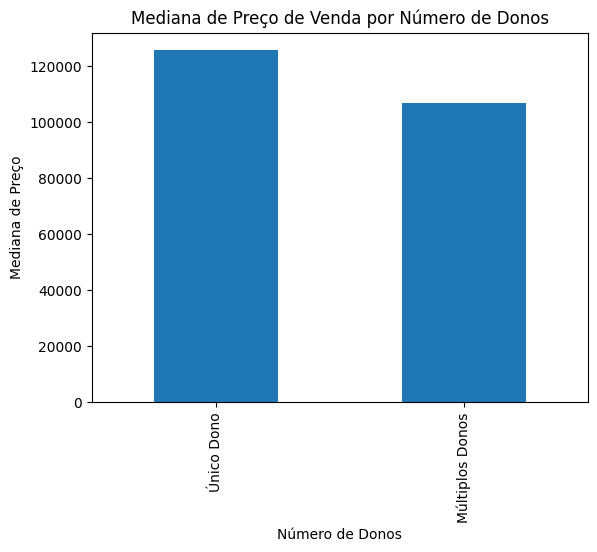

In [559]:
single_multiple_owner_prices = pd.Series([single_owner_cars, multiple_owner_cars],
                                         index=['Único Dono', 'Múltiplos Donos'])
single_multiple_owner_prices.plot(kind='bar')
plt.xlabel('Número de Donos')
plt.ylabel('Mediana de Preço')
plt.title('Mediana de Preço de Venda por Número de Donos')
plt.show()

Quando consideramos apenas o fator "Número de Donos", vemos que carros que possuem apenas um possui uma mediana maior do que carros com múltiplos donos, confirmando a hipótese criada.

### Hipótese 3: Carros ainda dentro da garantia de fábrica são mais caros do que carros fora da garantia?

In [560]:
warranty_cars = train_data[train_data['garantia_de_fábrica'] == 'Garantia de fábrica']['preco'].median()
no_warranty_cars = train_data[train_data['garantia_de_fábrica'].isnull()]['preco'].median()

print(f'Mediana de preço de carros com garantia de fábrica: {warranty_cars}')
print(f'Mediana de preço de carros sem garantia de fábrica: {no_warranty_cars}')


Mediana de preço de carros com garantia de fábrica: 148528.91060355975
Mediana de preço de carros sem garantia de fábrica: 108545.0154420076


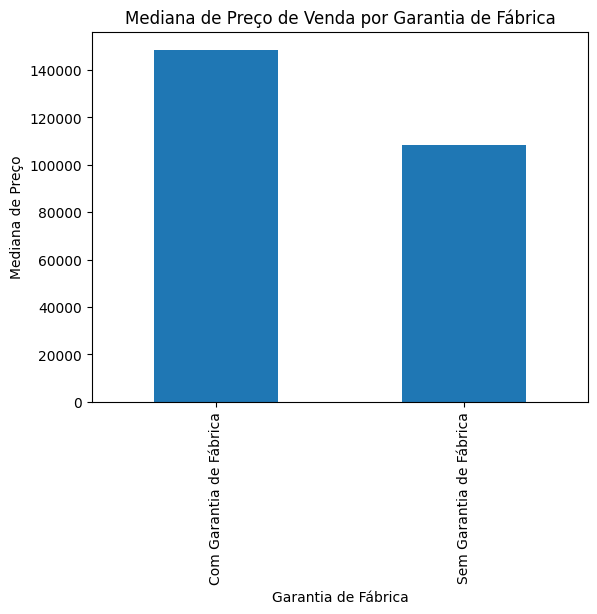

In [561]:
warranty_no_warranty_prices = pd.Series([warranty_cars, no_warranty_cars],
                                        index=['Com Garantia de Fábrica', 'Sem Garantia de Fábrica'])
warranty_no_warranty_prices.plot(kind='bar')
plt.xlabel('Garantia de Fábrica')
plt.ylabel('Mediana de Preço')
plt.title('Mediana de Preço de Venda por Garantia de Fábrica')
plt.show()

Quando consideramos apenas se o carro possuí ou não garantia de fábrica, os dados apoiam nossa hipótese de que estes carros são mais caros devido a diferença na mediana de preço entre os dois.

## 3) Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Primeiro conseguimos definir o problema como um de *regressão*: Estamos buscando prever uma variável contínua e não categórica, que é o preço.


Para realizar a previsão do preço a partir dos dados passamos a fazer certo processamentos dos dados: Dados que estão como Nulos, converter dados categóricos em numéricos, além de que dependendo do modelo a ser utilizado podemos utilizar técnicas de Padronização de Dados, Feature Engineering para criarmos outras variáveis (como idade do carro por exemplo), etc.


Neste caso específico, primeiro acabei definindo quais variáveis eu considerei importante usar e porquê:


**Colunas categóricas:**
As colunas utilizadas aqui em grande parte foram baseadas nas hipóteses ou perguntas de negócio analisadas, um exemplo é o estado_vendedor onde notamos que a mediana de um preço do carro acaba variando bastante dependendo de onde ele foi comprado, uma análise do tipo também foi feita com o câmbio por exemplo.

Temos outras colunas como 'cor' e 'versao' que por mais que não tenham sido analisadas muito a fundo no que tratamos acima, considero como fatores importantes pelo (breve) conhecimento da área de carros que possuo, porém é importante ressaltar que é claro que com um maior número de hipóteses e análisis em cada uma destas variáveis poderia se obter um resultado melhor.


**Colunas numéricas:**
As colunas numéricas seguiram o mesmo padrão de escolha que as categóricas, estas porém por possuírem números mais estatísticos como sua mediana, outliers, correlações, etc, nos permitiu ver também o que é mais "comum", como notamos na pergunta sobre o melhor estado a se comprar um carro popular e consideramos também a coluna "odometro" na análise, além do quão novo o carro era.


**Colunas excluídas:**
* Possuíam valores apenas vazios nela, ou
* Fatores que sempre serão diferentes (no caso o id)

Além disso houve exclusão de colunas que não considerei importantes devido a alta diferença na frequência entre um valor e outro e por não terem sido analisados. No caso de número de portas por exemplo, carros de 4 portas aparecem em 97% das linhas.


**Modelo escolhido:**

Foram testados mais de um modelo para se realizar a previsão (Regressão Logística, Árvore de Decisão e Random Forest), assim como foi utilizado de GridSearchCV para buscar o melhor possível junto dos melhores parâmetros. Com a soma dos melhores resultados e de análise, foi optado por utilizar o modelo de **Random Forest** por ser mais complexo e conseguir melhor tratar a grande quantidade de variáveis que possuímos, nos dando uma melhor estabilidade.

Por outro lado, entre seus pontos fracos podemos falar aqui também de sua maior complexidade, o que torna mais difícil de interpretar certos dados e também o torna computacionalmente mais intensivo.


Para a medida de performance dele foi escolhido usar o **Mean Absolute Error**, pois como estamos tratando de previsões de preço acredito que o cálculo médio do erro que temos (tanto para o menor quanto para o maior valor) nos ajuda a entender melhor o quão longe, em média, nossas previsões estão do correto, no caso possuímos uma margem de erro de: 25.513 mil reais. Também é uma métrica menos sensível aos outliers que encontramos.

### Pré-Procesamento dos Dados

In [562]:
cat_cols = ['marca', 'modelo', 'cambio', 'tipo', 'estado_vendedor', 'versao', 'tipo_vendedor', 'cidade_vendedor']
bin_cols = ['revisoes_concessionaria', 'veiculo_único_dono', 'ipva_pago', 'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda']
num_cols = ['ano_modelo', 'hodometro']
drop_cols = ['id', 'blindado', 'num_portas', 'cor', 'num_fotos', 'dono_aceita_troca', 'anunciante', 'troca', 'entrega_delivery']
# Preprocessamento nos dados de treinamento
X, y, te = preprocess_data(train_data, cat_cols, bin_cols, num_cols, 'preco', drop_cols)

In [563]:
# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Treinamento

In [564]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Parâmetros para GridSearchCV
#param_grid = {
#    'n_estimators': [300],
#    'max_depth': [20],
#    'min_samples_split': [10],
#}

# Floresta Aleatória
rf = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=20, min_samples_split=10)
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, predictions_rf)
print(f'MAE for Random Forest: {mae_rf}')

MAE for Random Forest: 25732.356773961965


### Previsão

In [565]:
# Exclui 'id' das colunas que serão excluídas dos dados
drop_cols_test = [col for col in drop_cols if col != 'id']
test_data_preprocessed, _ = preprocess_data(test_data, cat_cols, bin_cols, num_cols, te=te, drop_cols=drop_cols_test)

# Cria uma cópia dos dados com id
test_data_preprocessed_with_id = test_data_preprocessed.copy()

# Exclui a coluna id para a predição
test_data_preprocessed.drop('id', axis=1, inplace=True)

predictions_test = rf.predict(test_data_preprocessed)

output = pd.DataFrame({'id': test_data_preprocessed_with_id['id'], 'preco': predictions_test})
output


,id,preco
0,13518783164498355150900635905895481162,71116.01
1,299896161723793383246777788797566040330,98204.75
2,316180649972302128246133616457018378621,232308.81
3,222527157104148385909188217274642813298,96790.27
4,160460343059850745858546502614838368036,107445.97
...,...,...
9857,270530958308663978454359593206239054667,73308.95
9858,35444226755331218706378362485070904721,280350.37
9859,151927592621490440610866139377092833936,93325.13
9860,118047837484645467440786911677256539035,136431.78


In [566]:
output.to_csv('predicted.csv', index=False)